In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839, 0.0, 0.027),
    'dgreen': (0.341, 0.494, 0.094),
    'dblue': (0.063, 0.318, 0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [3]:
# dimensões do modelo
n = 6 # variáveis de estado
r = 2 # entradas de controle
l = 1 # entradas de distúrbio
m = 3 # saídas

In [4]:
A = np.array([
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
    [0, -7.36, 0.79, 0, 0.29, -0.14],
    [0, 73.58, -33.11, 0, -3.66, 2.16],
    [0, -58.86, 51.15, 0, 3.64, -2.44]
])

B = np.array([
    [0, 0],
    [0, 0],
    [0, 0],
    [0.61, 1.79],
    [-1.5, -27],
    [0.29, 30.54]
])

C = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]
])

D = np.array([
    [0, 0],
    [0, 0],
    [0, 0]
])

E = np.array([
    [0],
    [0],
    [0],
    [0.29],
    [-12],
    [18.54]
])

In [5]:
# Sistema em malha aberta na forma de espaço de estados
esp_estados = ct.ss(A, B, C, D)
esp_estados

StateSpace(array([[  0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ],
       [  0.  ,  -7.36,   0.79,   0.  ,   0.29,  -0.14],
       [  0.  ,  73.58, -33.11,   0.  ,  -3.66,   2.16],
       [  0.  , -58.86,  51.15,   0.  ,   3.64,  -2.44]]), array([[  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [  0.  ,   0.  ],
       [  0.61,   1.79],
       [ -1.5 , -27.  ],
       [  0.29,  30.54]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.]]))

### LQR

In [58]:
R = np.diag([10, 100])
Q = np.diag([10000,1,1000,1,1,1])

R,Q

(array([[ 10,   0],
        [  0, 100]]),
 array([[10000,     0,     0,     0,     0,     0],
        [    0,     1,     0,     0,     0,     0],
        [    0,     0,  1000,     0,     0,     0],
        [    0,     0,     0,     1,     0,     0],
        [    0,     0,     0,     0,     1,     0],
        [    0,     0,     0,     0,     0,     1]]))

In [59]:
K, P, CLpoles = ct.lqr(esp_estados, Q, R)
CLpoles

array([-11.711505 +2.3256347j , -11.711505 -2.3256347j ,
        -3.0511801+2.174324j  ,  -3.0511801-2.174324j  ,
        -3.899408 +0.90076333j,  -3.899408 -0.90076333j], dtype=complex64)

### Seguidor por modelo assumido

In [60]:
# degrau ou rampa
A_r = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0]
    ])

In [61]:
# seleção de variável para seguir referência
M_seg = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0]]) # tem que ser 2 saídas para que o sistema seja quadrado (M@ A_cl_inv @ B fica 2x2)

# inversa da matriz de estados em MF
A_cl_inv = np.linalg.inv(A - B @ K)

# ganho de pré-alimentação
N_seg = np.linalg.inv(M_seg @ A_cl_inv @ B) @ M_seg @ A_cl_inv
G_r = N_seg @ (A - A_r)

In [62]:
# matrizes do sistema estendido em malha fechada
A_ex_cl = np.block([[A - B @ G_r, B @ (K - G_r)], 
                    [A_r - A + B @ G_r, A_r - B @ (K - G_r)]])
E_ex_cl = np.block([[E], [np.zeros((n, l))]])
K_ex = np.block([[-G_r, K - G_r]])

# forma de espaço de estados
cl_esp_estados = ct.ss(A_ex_cl, E_ex_cl, K_ex, 0)
cl_esp_estados

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  7.30208094e+01,  2.75647747e+01,
         2.28844993e+01,  1.86571863e+01,  1.34245768e+01,
        -2.62555361e+01,  1.32937913e+00, -1.33745195e+01,
        -1.40456535e-13, -1.15671916e-13, -7.66919861e-14],
       [ 0.00000000e+00, -3.53163075e+02,

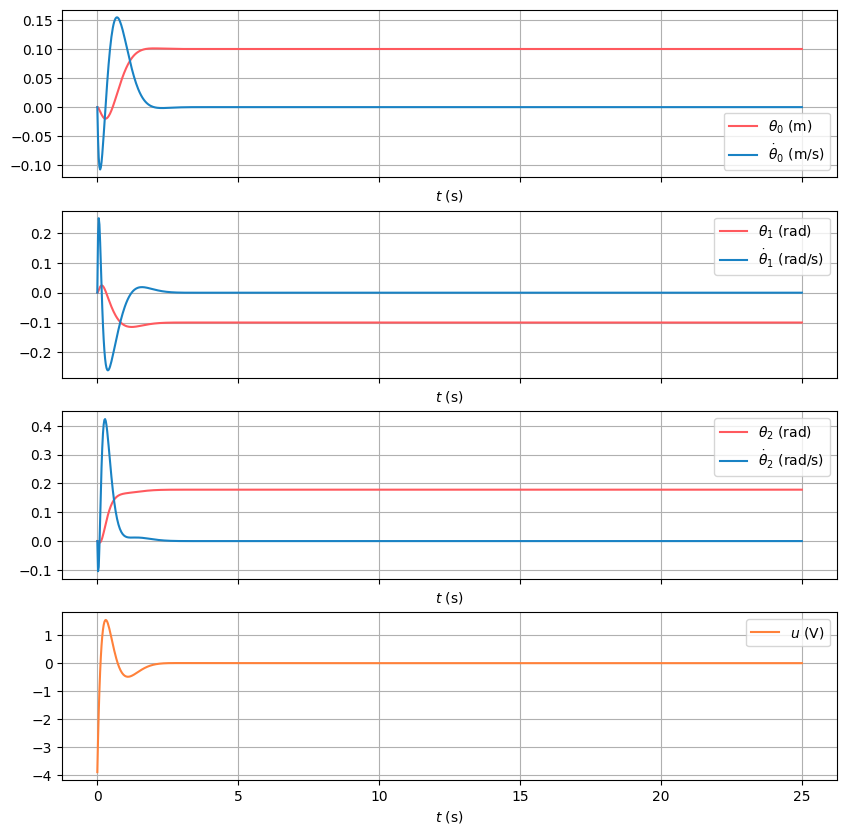

In [63]:
ts = np.linspace(0, 25, 1001)
w = 0
x0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
      0.1, -0.1, 0.0, 0.0, 0.0, 0.0]

t, u, x = ct.forced_response(cl_esp_estados, U=0, T=ts, X0=x0, return_x=True)

fig, (state_pend, state_base, error_base, control_input) = plt.subplots(
    4, 1, figsize=(10, 10), sharex=True)

state_pend.plot(t, x[0, :], color=cp['red'], label=r'$\theta_0$ (m)')
state_pend.plot(t, x[3, :], color=cp['blue'], label=r'$\dot \theta_0$ (m/s)')
state_pend.set_xlabel(r'$t$ (s)')
state_pend.legend()
state_pend.grid()

state_base.plot(t, x[1, :], color=cp['red'], label=r'$\theta_1$ (rad)')
state_base.plot(t, x[4, :], color=cp['blue'], label=r'$\dot \theta_1$ (rad/s)')
state_base.set_xlabel(r'$t$ (s)')
state_base.legend()
state_base.grid()

error_base.plot(t, x[2, :], color=cp['red'], label=r'$\theta_2$ (rad)')
error_base.plot(t, x[5, :], color=cp['blue'], label=r'$\dot \theta_2$ (rad/s)')
error_base.set_xlabel(r'$t$ (s)')
error_base.legend()
error_base.grid()

control_input.plot(t, u[0, :], color=cp['orange'], label=r'$u$ (V)')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

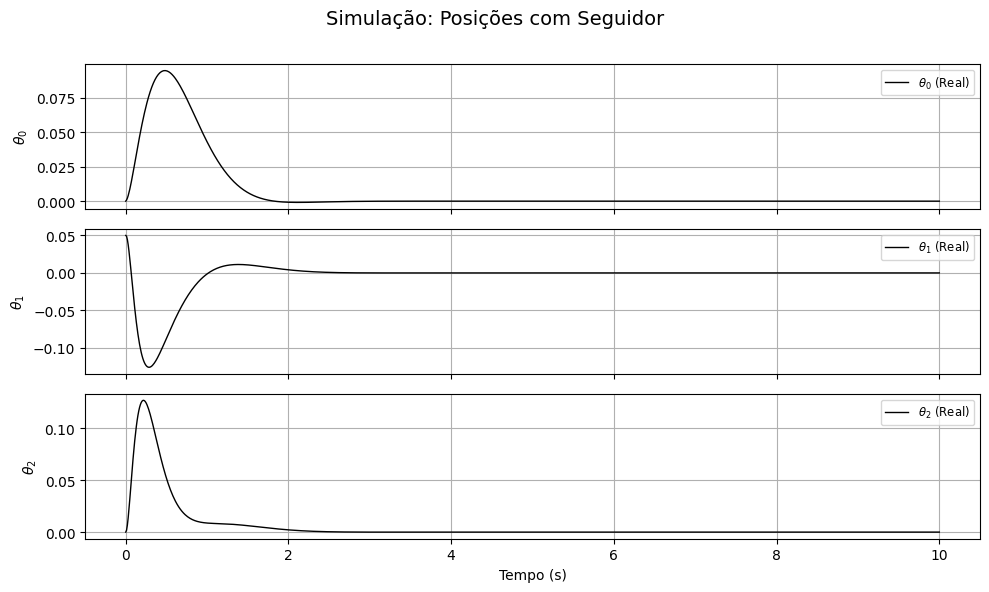

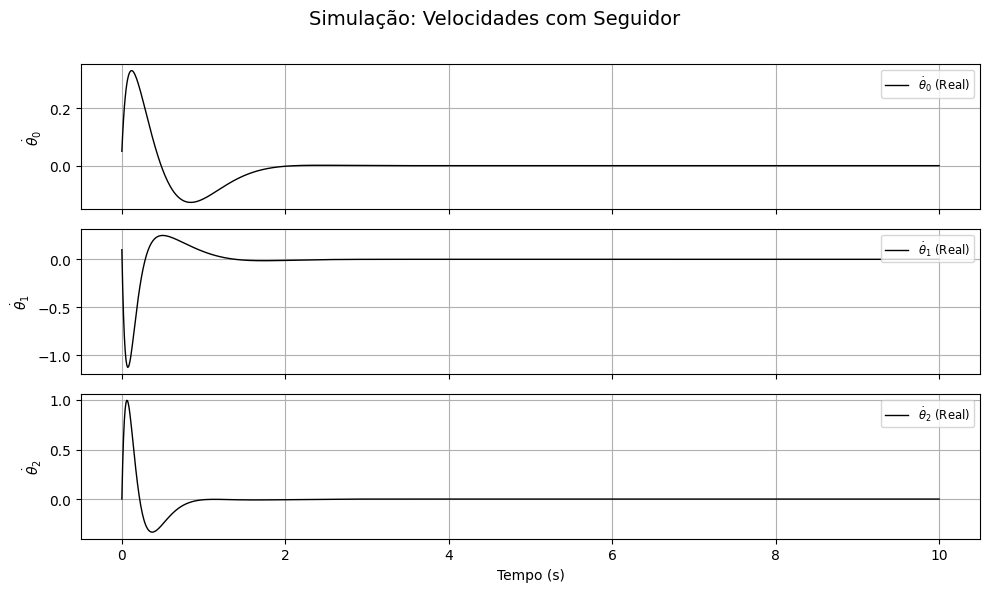

In [64]:
ts = np.linspace(0, 10, 1001)
dt = ts[1] - ts[0]
w = np.zeros((E.shape[1], len(ts)))

p_start = 5.0
p_dur = dt
p_mag = 0.0

idx_start = np.where(ts >= p_start)[0][0]
idx_end = np.where(ts >= p_start + p_dur)[0][0]
if idx_start == idx_end and ts[idx_start] < p_start + p_dur:
    if idx_end + 1 < len(ts):
        idx_end += 1
    else:
        idx_end = len(ts)
w[0, idx_start:idx_end] = p_mag / dt

x0 = [0.0, 0.05, 0.0, 0.05, 0.1, 0.0,
      0.0, -0.05, 0.0, 0.0, 0.0, 0.0]              # seguidor

t_sim, u_controls, x_composite_states = ct.forced_response(cl_esp_estados, U=w, T=ts, X0=x0, return_x=True)

state_labels = [
    r'$\theta_0$', r'$\theta_1$', r'$\theta_2$',
    r'$\dot{\theta}_0$', r'$\dot{\theta}_1$', r'$\dot{\theta}_2$'
]

fig1, axs1 = plt.subplots(3, 1, figsize=(10, 2 * 3), sharex=True)

for i, idx in enumerate([0,1,2]):
    axs1[i].plot(t_sim, x_composite_states[idx, :], linewidth=1.0, color='k', label=state_labels[idx] + ' (Real)')
    axs1[i].set_ylabel(state_labels[idx])
    axs1[i].legend(loc='upper right', fontsize='small')
    axs1[i].grid(True)

axs1[-1].set_xlabel('Tempo (s)')

fig1.suptitle('Simulação: Posições com Seguidor', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

fig2, axs2 = plt.subplots(3, 1, figsize=(10, 2 * 3), sharex=True)

for i, idx in enumerate([3,4,5]):
    axs2[i].plot(t_sim, x_composite_states[idx, :], linewidth=1.0, color='k', label=state_labels[idx] + ' (Real)')
    axs2[i].set_ylabel(state_labels[idx])
    axs2[i].legend(loc='upper right', fontsize='small')
    axs2[i].grid(True)

axs2[-1].set_xlabel('Tempo (s)')

fig2.suptitle('Simulação: Velocidades com Seguidor', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()